In [ ]:
pip install -U langgraph langchain_openai langchain_community

In [475]:
from langchain_ollama import OllamaLLM
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.agent_toolkits.sql.base import create_sql_agent
from sqlalchemy import create_engine
from sqlalchemy import text
import requests

In [476]:
# Set up database connection to the new isolated database
engine = create_engine('postgresql+psycopg2://postgres@localhost:5432/FPL')

# Create a SQLDatabase object
db = SQLDatabase(engine)

In [527]:
print(db.get_usable_table_names())


['clubs', 'fixtures_23_24', 'merged_gws_23_24', 'teams_23_24']


In [528]:
db.run("SELECT * FROM merged_gws_23_24 LIMIT 10;")

"[('Femi Seriki', 'DEF', 'Sheffield Utd', 0.5, 0, 0, 0, 0, 0.0, 653, 0.0, 0.0, 0.0, 0.0, 7, 0, 0, 0.0, datetime.datetime(2023, 8, 12, 15, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 0, 8, 0, 0, 0, 0, 0, 0.0, 0, 1, 0, 0, 0, 0, 4.0, 0, 1, 0.0, 0.0), ('Jack Hinshelwood', 'MID', 'Brighton', 1.5, 0, 0, 0, 0, 0.0, 621, 0.0, 0.0, 0.0, 0.0, 4, 0, 0, 0.0, datetime.datetime(2023, 8, 12, 15, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 0, 12, 0, 0, 0, 0, 0, 0.0, 0, 1, 4, 0, 0, 0, 4.5, 0, 1, 0.0, 0.0), ('Jadon Sancho', 'MID', 'Man Utd', 3.0, 0, 0, 4, 0, 11.3, 397, 0.05, 0.05, 0.0, 1.08, 10, 0, 0, 2.3, datetime.datetime(2023, 8, 14, 20, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 22, 20, 0, 0, 0, 0, 0, 0.1, 0, 0, 1, 1, 0, 0, 7.0, 0, 1, 0.0, 0.14285714285714285), ('Rhys Norrington-Davies', 'DEF', 'Sheffield Utd', 0.1, 0, 0, 0, 0, 0.0, 487, 0.0, 0.0, 0.0, 0.0, 7, 0, 0, 0.0, datetime.datetime(2023, 8, 12, 15, 0, tzinfo=datetime.timezone(dateti

In [529]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

In [530]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    try:
        tool_node = ToolNode(tools)
        return tool_node.with_fallbacks(
            [RunnableLambda(handle_tool_error)], 
            exception_key="error"
        )
    except Exception as e:
        print(f"Error creating tool node: {e}")
        # Return a fallback node that always raises an error
        return RunnableLambda(lambda _: {"messages": [AIMessage(content=f"Tool node creation failed: {e}")]})


def handle_tool_error(state) -> dict:
    error = state.get("error")
    
    # Check if the last message is an AIMessage or ToolMessage
    last_message = state["messages"][-1]
    
    # If it's a ToolMessage or AIMessage without tool_calls, create a generic error message
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\nPlease fix your query.",
                tool_call_id="generic_error"
            )
        ]
    }

In [531]:
# Configure LLM
llm = OllamaLLM(
    model="llama3.2",
    base_url="http://localhost:11434",
    temperature=0.7,
    top_p=0.9,
    format='json',
    prompt_template="""You are a helpful assistant interacting with the FPL database which contains the following tables: 
    clubs, fixtures_23_24, merged_gws_23_24, teams_23_24
    If the question is about a premier league football team, their ids number or their overall strength during the season, choose the teams_23_24 Table !
    If the question is about a premier league game, the score of that particular game and the difficulty for one of the team playing, choose the fixtures_23_24 Table !
    If the question is about a premier league PLAYER, choose the merged_gws_23_24 tables
    You must only interact with these tables. 
    Always respond in this JSON format:
    {{
        "Action": "<action_name>",
        "Action Input": "<input_value>"
    }}
    If you cannot process the query, return:
    {{
        "Action": "None",
        "Action Input": "I cannot process this query."
    }}
    """
)

In [532]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("clubs"))

clubs, fixtures_23_24, merged_gws_23_24, teams_23_24

CREATE TABLE clubs (
	name TEXT
)

/*
3 rows from clubs table:
name
Arsenal
Aston Villa
Bournemouth
*/


In [533]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM merged_gws_23_24 LIMIT 10;"))

[('Femi Seriki', 'DEF', 'Sheffield Utd', 0.5, 0, 0, 0, 0, 0.0, 653, 0.0, 0.0, 0.0, 0.0, 7, 0, 0, 0.0, datetime.datetime(2023, 8, 12, 15, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 0, 8, 0, 0, 0, 0, 0, 0.0, 0, 1, 0, 0, 0, 0, 4.0, 0, 1, 0.0, 0.0), ('Jack Hinshelwood', 'MID', 'Brighton', 1.5, 0, 0, 0, 0, 0.0, 621, 0.0, 0.0, 0.0, 0.0, 4, 0, 0, 0.0, datetime.datetime(2023, 8, 12, 15, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 0, 12, 0, 0, 0, 0, 0, 0.0, 0, 1, 4, 0, 0, 0, 4.5, 0, 1, 0.0, 0.0), ('Jadon Sancho', 'MID', 'Man Utd', 3.0, 0, 0, 4, 0, 11.3, 397, 0.05, 0.05, 0.0, 1.08, 10, 0, 0, 2.3, datetime.datetime(2023, 8, 14, 20, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 22, 20, 0, 0, 0, 0, 0, 0.1, 0, 0, 1, 1, 0, 0, 7.0, 0, 1, 0.0, 0.14285714285714285), ('Rhys Norrington-Davies', 'DEF', 'Sheffield Utd', 0.1, 0, 0, 0, 0, 0.0, 487, 0.0, 0.0, 0.0, 0.0, 7, 0, 0, 0.0, datetime.datetime(2023, 8, 12, 15, 0, tzinfo=datetime.timezone(datetim

In [534]:
from langchain_ollama import OllamaLLM
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from sqlalchemy import create_engine, text
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from typing import Any
import json
import traceback

# Query checking and execution
def check_and_execute_query(query):
    prompt = f"""You are a SQL expert checking a database query
Analyze the following SQL query: {query}

Requirements for response:
1. If the query is valid, return a JSON with:
   {{"Action": "Correctly formatted query", "Action Input": "{query}"}}
2. If the query has issues, return a detailed JSON explaining the problems:
   {{"Action": "Incorrectly formatted query", "Explanation": "Specific error details"}}

Your response must be in strict JSON format."""

    try:
        print("Sending query to LLM...")
        response = llm(prompt)
        print("Raw LLM Response:", response)

        # Parse the LLM's response
        parsed_response = json.loads(response)

        if parsed_response.get('Action') == 'Correctly formatted query':
            query_to_execute = parsed_response.get('Action Input', '')
            if query_to_execute:
                return db_query_tool(query_to_execute)
            else:
                return "Unable to process query"
        elif parsed_response.get('Action') == 'Incorrectly formatted query':
            explanation = parsed_response.get('Explanation', 'No explanation provided')
            print(f"Query Formatting Issue: {explanation}")
            return f"Query Formatting Error: {explanation}"
        else:
            return "Unable to process query"

    except json.JSONDecodeError:
        print("JSON Parsing Error. Full response:")
        print(response)
        return "Error: Could not parse LLM response as JSON"
    except Exception as e:
        print("Unexpected error:")
        traceback.print_exc()
        return f"Unexpected error: {str(e)}"

try:
    query = "SELECT * FROM clubs;"
    result = check_and_execute_query(query)
    print("Final Result:", result)
except Exception as e:
    print(f"Error in query chain: {e}")


Sending query to LLM...
Raw LLM Response: {
  "Action": "Incorrectly formatted query",
  "Explanation": {
    "Reasons": [
      {
        "CodeIssue": "Missing semicolon at the end of the statement"
      }
    ]
  }
}
Query Formatting Issue: {'Reasons': [{'CodeIssue': 'Missing semicolon at the end of the statement'}]}
Final Result: Query Formatting Error: {'Reasons': [{'CodeIssue': 'Missing semicolon at the end of the statement'}]}


In [535]:
# Typing and LangGraph imports
from typing import Annotated, Literal, Any
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, ToolMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.messages import ToolMessage, AIMessage, AnyMessage, HumanMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
import json
import traceback
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

# LangGraph imports
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from langchain_core.runnables.config import RunnableConfig

# Set a higher recursion limit
RunnableConfig.recursion_limit = 50

In [536]:
# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a new graph
workflow = StateGraph(State)


In [537]:
# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }

def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Validate the user's query using the schema information.
    """
    last_user_message = state["messages"][-1].content  # User's query
    prompt = f"""
    You are a SQL expert. The database contains 4 tables, here is the schema of each one, Please use this schema when querying or describing the data.:

    1) Table clubs: containing a list of all the clubs . Only one column name which contain the name of the premier league clubs.
    2) Table fixtures_23_24:  If the question is about a premier league game, the score of that particular game and the difficulty for one of the team playing,CHOOSE THIS TABLE
    - **GW**: An integer representing the game week number.
    - **game_id**: An integer representing the unique identifier for each game.
    - **kickoff_time**: A timestamp in ISO 8601 format representing the kickoff time of the game.
    - **team_a**: An integer representing the ID of the away team.
    - **team_a_score**: An integer representing the score of the away team.
    - **team_h**: An integer representing the ID of the home team.
    - **team_h_score**: An integer representing the score of the home team.
    - **team_h_difficulty**: An integer representing the difficulty rating of the home team.
    - **team_a_difficulty**: An integer representing the difficulty rating of the away team.
    3) Table merged_gws_23_24: If the question is about a premier league PLAYER, CHOOSE THIS TABLE
    - **player_name**: A string representing the name of the player.
    - **position**: A string indicating the player's position (e.g., DEF, MID, GK).
    - **team**: A string representing the name of the player's team.
    - **xP**: A float representing the player's expected points.
    - **assists**: An integer representing the number of assists made by the player.
    - **bonus**: An integer representing the bonus points awarded to the player.
    - **bps**: An integer representing the player's bonus points system score.
    - **clean_sheets**: An integer indicating the number of clean sheets kept by the player.
    - **creativity**: A float representing the player's creativity score.
    - **element**: An integer that uniquely identifies the player.
    - **expected_assists**: A float representing the expected number of assists.
    - **expected_goal_involvements**: A float representing the expected number of goal involvements.
    - **expected_goals**: A float indicating the expected number of goals scored by the player.
    - **expected_goals_conceded**: A float representing the expected number of goals conceded.
    - **fixture**: An integer indicating the fixture number.
    - **goals_conceded**: An integer representing the actual number of goals conceded.
    - **goals_scored**: An integer representing the actual number of goals scored by the player.
    - **ict_index**: A float indicating the player's Influence, Creativity, and Threat index score.
    - **kickoff_time**: A timestamp (ISO 8601 format) representing the fixture's kickoff time.
    - **minutes**: An integer indicating the total minutes played by the player.
    - **opponent_team**: An integer representing the ID of the opposing team.
    - **own_goals**: An integer representing the number of own goals scored by the player.
    - **penalties_missed**: An integer indicating the number of penalties missed by the player.
    - **penalties_saved**: An integer representing the number of penalties saved by the player.
    - **red_cards**: An integer representing the number of red cards received by the player.
    - **saves**: An integer indicating the number of saves made by the player (for goalkeepers).
    - **selected**: An integer representing the number of times the player has been selected.
    - **starts**: An integer indicating the number of times the player started a fixture.
    - **team_a_score**: An integer representing the score of the away team.
    - **team_h_score**: An integer representing the score of the home team.
    - **total_points**: An integer indicating the total fantasy points scored by the player.
    - **transfers_in**: An integer representing the number of transfers in.
    - **transfers_out**: An integer representing the number of transfers out.
    - **value**: A float representing the current value of the player in the game.
    - **yellow_cards**: An integer representing the number of yellow cards received by the player.
    - **GW**: An integer representing the game week number.
    4) teams_23_24: If the question is about a premier league football team, their ids number or their overall strength during the season , CHOOSE THIS TABLE
    - **team_id**: An integer representing the unique identifier for each team.
    - **name**: A string representing the name of the team.
    - **short_name**: A string representing the team's short abbreviation.
    - **strength**: An integer representing the overall strength rating of the team.
    - **strength_overall_home**: An integer representing the team's overall strength when playing at home.
    - **strength_overall_away**: An integer representing the team's overall strength when playing away.
    - **strength_attack_home**: An integer representing the team's attacking strength when playing at home.
    - **strength_attack_away**: An integer representing the team's attacking strength when playing away.
    - **strength_defence_home**: An integer representing the team's defensive strength when playing at home.
    - **strength_defence_away**: An integer representing the team's defensive strength when playing away.


    Validate the following query: "{last_user_message}"

    Respond in this format:
    {{
      "Action": "Correctly formatted query",
      "Action Input": "{last_user_message}"
    }}

    If the query is incorrect, respond:
    {{
      "Action": "Incorrectly formatted query",
      "Explanation": "Detailed explanation of the query's issues."
    }}
    """
    try:
        # Send the prompt to the LLM
        print("Validating query with LLM...")
        response = llm(prompt)
        print("Raw LLM Response:", response)

        # Parse and handle the response
        response_data = json.loads(response)
        if response_data.get("Action") == "Correctly formatted query":
            return {
                "messages": [
                    AIMessage(content="Query validation passed.")
                ]
            }
        elif response_data.get("Action") == "Incorrectly formatted query":
            explanation = response_data.get("Explanation", "No explanation provided.")
            return {
                "messages": [
                    AIMessage(content=f"Query validation failed: {explanation}")
                ]
            }
        else:
            return {
                "messages": [
                    AIMessage(content="Unexpected response format during validation.")
                ]
            }
    except json.JSONDecodeError:
        return {
            "messages": [
                AIMessage(content="Error: Could not parse LLM response as JSON.")
            ]
        }
    except Exception as e:
        traceback.print_exc()
        return {
            "messages": [
                AIMessage(content=f"Unexpected error: {str(e)}")
            ]
        }



workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

def choose_the_right_DDL_table(state: State) -> dict[str, list[AIMessage]]:
    """
    A node function to choose the relevant tables based on the user's question and available schema.
    If the relevant table is found, the tool is invoked to provide schema details.
    """
    prompt = """Your job is to choose the relevant tables based on the question and available tables.
1) Table clubs: containing a list of all the clubs . Only one column name which contain the name of the premier league clubs.
    2) Table fixtures_23_24:  If the question is about a premier league game, the score of that particular game and the difficulty for one of the team playing, CHOOSE THIS TABLE
    - **GW**: An integer representing the game week number.
    - **game_id**: An integer representing the unique identifier for each game.
    - **kickoff_time**: A timestamp in ISO 8601 format representing the kickoff time of the game.
    - **team_a**: An integer representing the ID of the away team.
    - **team_a_score**: An integer representing the score of the away team.
    - **team_h**: An integer representing the ID of the home team.
    - **team_h_score**: An integer representing the score of the home team.
    - **team_h_difficulty**: An integer representing the difficulty rating of the home team.
    - **team_a_difficulty**: An integer representing the difficulty rating of the away team.
    3) Table merged_gws_23_24: If the question is about a premier league PLAYER, CHOOSE THIS TABLE
    - **player_name**: A string representing the name of the player.
    - **position**: A string indicating the player's position (e.g., DEF, MID, GK).
    - **team**: A string representing the name of the player's team.
    - **xP**: A float representing the player's expected points.
    - **assists**: An integer representing the number of assists made by the player.
    - **bonus**: An integer representing the bonus points awarded to the player.
    - **bps**: An integer representing the player's bonus points system score.
    - **clean_sheets**: An integer indicating the number of clean sheets kept by the player.
    - **creativity**: A float representing the player's creativity score.
    - **element**: An integer that uniquely identifies the player.
    - **expected_assists**: A float representing the expected number of assists.
    - **expected_goal_involvements**: A float representing the expected number of goal involvements.
    - **expected_goals**: A float indicating the expected number of goals scored by the player.
    - **expected_goals_conceded**: A float representing the expected number of goals conceded.
    - **fixture**: An integer indicating the fixture number.
    - **goals_conceded**: An integer representing the actual number of goals conceded.
    - **goals_scored**: An integer representing the actual number of goals scored by the player.
    - **ict_index**: A float indicating the player's Influence, Creativity, and Threat index score.
    - **kickoff_time**: A timestamp (ISO 8601 format) representing the fixture's kickoff time.
    - **minutes**: An integer indicating the total minutes played by the player.
    - **opponent_team**: An integer representing the ID of the opposing team.
    - **own_goals**: An integer representing the number of own goals scored by the player.
    - **penalties_missed**: An integer indicating the number of penalties missed by the player.
    - **penalties_saved**: An integer representing the number of penalties saved by the player.
    - **red_cards**: An integer representing the number of red cards received by the player.
    - **saves**: An integer indicating the number of saves made by the player (for goalkeepers).
    - **selected**: An integer representing the number of times the player has been selected.
    - **starts**: An integer indicating the number of times the player started a fixture.
    - **team_a_score**: An integer representing the score of the away team.
    - **team_h_score**: An integer representing the score of the home team.
    - **total_points**: An integer indicating the total fantasy points scored by the player.
    - **transfers_in**: An integer representing the number of transfers in.
    - **transfers_out**: An integer representing the number of transfers out.
    - **value**: A float representing the current value of the player in the game.
    - **yellow_cards**: An integer representing the number of yellow cards received by the player.
    - **GW**: An integer representing the game week number.
    4) teams_23_24:If the question is about a premier league football team, their ids number or their overall strength during the season CHOOSE THIS TABLE
    - **team_id**: An integer representing the unique identifier for each team.
    - **name**: A string representing the name of the team.
    - **short_name**: A string representing the team's short abbreviation.
    - **strength**: An integer representing the overall strength rating of the team.
    - **strength_overall_home**: An integer representing the team's overall strength when playing at home.
    - **strength_overall_away**: An integer representing the team's overall strength when playing away.
    - **strength_attack_home**: An integer representing the team's attacking strength when playing at home.
    - **strength_attack_away**: An integer representing the team's attacking strength when playing away.
    - **strength_defence_home**: An integer representing the team's defensive strength when playing at home.
    - **strength_defence_away**: An integer representing the team's defensive strength when playing away.
    If you find the relevant table, answer with only one word: Table found."""
    
    try:
        # Send the prompt to the LLM
        print("Sending query to LLM...")
        response = llm(prompt)
        print("Raw LLM Response:", response)
        
        if response.strip() == "Table found":
            # Invoke the tool and return its response
            return {
                "messages": [get_schema_tool.invoke({"messages": [state["messages"][-1]]})]
            }
        else:
            # Handle the case where no relevant table is found
            return {
                "messages": [
                    AIMessage(content="Unable to process query. No relevant table found.")
                ]
            }
    except Exception as e:
        # Handle unexpected errors
        print("Unexpected error:")
        traceback.print_exc()
        return {
            "messages": [
                AIMessage(content=f"Unexpected error: {str(e)}")
            ]
        }

# Add the node to the workflow
workflow.add_node(
    "choose_the_right_DDL_table",
    choose_the_right_DDL_table
)

# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")

def generate_query(state: State) -> dict[str, list[AIMessage]]:
    """
    A node function to generate a SQL query based on the user's input and schema.
    """
    last_user_message = state["messages"][-1].content  # Get the user's query
    prompt = f"""
    You are a SQL expert interacting with a database that contains the following schema:

1) Table clubs: containing a list of all the clubs . Only one column name which contain the name of the premier league clubs.
    2) Table fixtures_23_24:  If the question is about a premier league game, the score of that particular game and the difficulty for one of the team playing, CHOOSE THIS TABLE
    - **GW**: An integer representing the game week number.
    - **game_id**: An integer representing the unique identifier for each game.
    - **kickoff_time**: A timestamp in ISO 8601 format representing the kickoff time of the game.
    - **team_a**: An integer representing the ID of the away team.
    - **team_a_score**: An integer representing the score of the away team.
    - **team_h**: An integer representing the ID of the home team.
    - **team_h_score**: An integer representing the score of the home team.
    - **team_h_difficulty**: An integer representing the difficulty rating of the home team.
    - **team_a_difficulty**: An integer representing the difficulty rating of the away team.
    3) Table merged_gws_23_24: If the question is about a premier league PLAYER, CHOOSE THIS TABLE
    - **player_name**: A string representing the name of the player.
    - **position**: A string indicating the player's position (e.g., DEF, MID, GK).
    - **team**: A string representing the name of the player's team.
    - **xP**: A float representing the player's expected points.
    - **assists**: An integer representing the number of assists made by the player.
    - **bonus**: An integer representing the bonus points awarded to the player.
    - **bps**: An integer representing the player's bonus points system score.
    - **clean_sheets**: An integer indicating the number of clean sheets kept by the player.
    - **creativity**: A float representing the player's creativity score.
    - **element**: An integer that uniquely identifies the player.
    - **expected_assists**: A float representing the expected number of assists.
    - **expected_goal_involvements**: A float representing the expected number of goal involvements.
    - **expected_goals**: A float indicating the expected number of goals scored by the player.
    - **expected_goals_conceded**: A float representing the expected number of goals conceded.
    - **fixture**: An integer indicating the fixture number.
    - **goals_conceded**: An integer representing the actual number of goals conceded.
    - **goals_scored**: An integer representing the actual number of goals scored by the player.
    - **ict_index**: A float indicating the player's Influence, Creativity, and Threat index score.
    - **kickoff_time**: A timestamp (ISO 8601 format) representing the fixture's kickoff time.
    - **minutes**: An integer indicating the total minutes played by the player.
    - **opponent_team**: An integer representing the ID of the opposing team.
    - **own_goals**: An integer representing the number of own goals scored by the player.
    - **penalties_missed**: An integer indicating the number of penalties missed by the player.
    - **penalties_saved**: An integer representing the number of penalties saved by the player.
    - **red_cards**: An integer representing the number of red cards received by the player.
    - **saves**: An integer indicating the number of saves made by the player (for goalkeepers).
    - **selected**: An integer representing the number of times the player has been selected.
    - **starts**: An integer indicating the number of times the player started a fixture.
    - **team_a_score**: An integer representing the score of the away team.
    - **team_h_score**: An integer representing the score of the home team.
    - **total_points**: An integer indicating the total fantasy points scored by the player.
    - **transfers_in**: An integer representing the number of transfers in.
    - **transfers_out**: An integer representing the number of transfers out.
    - **value**: A float representing the current value of the player in the game.
    - **yellow_cards**: An integer representing the number of yellow cards received by the player.
    - **GW**: An integer representing the game week number.
    4) teams_23_24: If the question is about a premier league football team, their ids number or their overall strength during the season
    - **team_id**: An integer representing the unique identifier for each team.
    - **name**: A string representing the name of the team.
    - **short_name**: A string representing the team's short abbreviation.
    - **strength**: An integer representing the overall strength rating of the team.
    - **strength_overall_home**: An integer representing the team's overall strength when playing at home.
    - **strength_overall_away**: An integer representing the team's overall strength when playing away.
    - **strength_attack_home**: An integer representing the team's attacking strength when playing at home.
    - **strength_attack_away**: An integer representing the team's attacking strength when playing away.
    - **strength_defence_home**: An integer representing the team's defensive strength when playing at home.
    - **strength_defence_away**: An integer representing the team's defensive strength when playing away.

    Your task:
    - Generate a syntactically correct PostgreSQL query that answers the user's question: "{last_user_message}"
    - Include any relevant notes about your query logic in the response.

    Respond in this exact JSON format:
    {{
      "query": "Generated SQL query here",
      "notes": "Explanation of the query logic"
    }}

    If you cannot generate a query, respond:
    {{
      "error": "Explanation of why the query cannot be generated"
    }}
    """
    try:
        # Send the prompt to the LLM
        print("Sending query generation request to LLM...")
        response = llm(prompt)
        print("Raw LLM Response:", response)

        # Parse and handle the response
        response_data = json.loads(response)
        if "query" in response_data:
            query_to_execute = response_data["query"]
            return {
                "messages": [
                    AIMessage(content=f"Query generated successfully: {query_to_execute}")
                ]
            }
        elif "error" in response_data:
            error_message = response_data["error"]
            return {
                "messages": [
                    AIMessage(content=f"Query generation failed: {error_message}")
                ]
            }
        else:
            return {
                "messages": [
                    AIMessage(content="Unexpected response format from the LLM.")
                ]
            }
    except json.JSONDecodeError:
        return {
            "messages": [
                AIMessage(content="Error: Could not parse LLM response as JSON.")
            ]
        }
    except Exception as e:
        traceback.print_exc()
        return {
            "messages": [
                AIMessage(content=f"Unexpected error: {str(e)}")
            ]
        }


# Add the node to the workflow
workflow.add_node("generate_query",generate_query)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

def should_continue(state: State) -> Literal[END, "correct_query", "generate_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, transition to END
    if getattr(last_message, "tool_calls", None):
        return END

    # If there's an error, transition to `generate_query`
    if last_message.content.startswith("Error:"):
        return "generate_query"
    
    # Otherwise, transition to `correct_query`
    return "correct_query"



# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "choose_the_right_DDL_table")
workflow.add_edge("choose_the_right_DDL_table", "get_schema_tool")
workflow.add_edge("get_schema_tool", "generate_query")  # Updated here
workflow.add_conditional_edges(
    "generate_query",  # Updated here
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "generate_query")  # Updated here


# Compile the workflow into a runnable
app = workflow.compile()


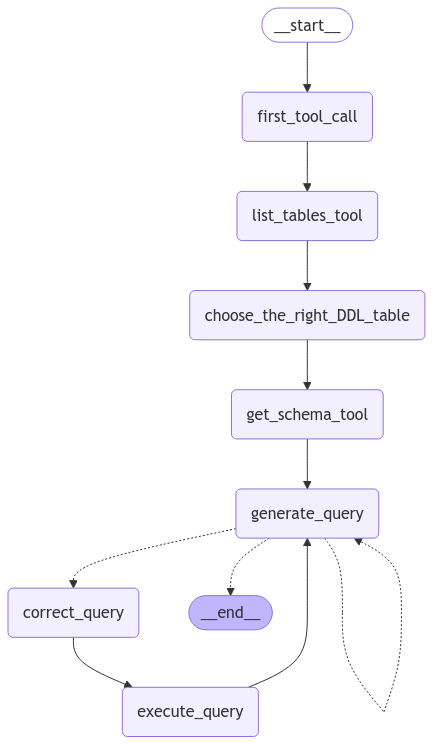

In [538]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [544]:
# Import necessary classes for message types
from langchain_core.messages import HumanMessage

# Prepare the input state
input_state = {
    "messages": [
        HumanMessage(content="select from teams_23_24 where name is Arsenal ")
    ]
}

# Invoke the workflow
result = app.invoke(input_state)

# Print the result
print("Workflow Result:")
print(result)

Sending query to LLM...
Raw LLM Response: {  "Table_found": " fixtures_23_24",  "Table_found": "merged_gws_23_24",  "Table_found": "teams_23_24"}
Sending query generation request to LLM...
Raw LLM Response: {
  "query": "-- Since no relevant table is specified in the question, we can't generate a query that will give us accurate results. We need more information about the type of data being asked for or the team/club/fixture details.",
  "notes": "To solve this problem, we would need to know which specific piece of data the user is looking for (e.g., current score of a particular team, player stats, fixture info). Without this information, it's impossible to generate an accurate SQL query. We could potentially ask follow-up questions to clarify the user's request or suggest possible queries if the user provides more context."
}
Validating query with LLM...
Raw LLM Response: {
  "Action": "Incorrectly formatted query",
  "Explanation": "The provided query does not specify which table(s)

KeyboardInterrupt: 